In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [ ]:
"""
this should be the final test
we train on the pred days unsen during the making of the secondary df
we should also take this data to complete the secondary df
we should approximate actual predictions as closely as possibe which means predicting only on one day

we ultimately want a portfolio of around 20, we know that the percent of of 0's is 0.16, so we need to pass atleast 125 stocks to the secondary classifier
we know that when removing identical labels, around half was removed, so we need 250 stocks picked for each pred day
we should keep the original tickers aswell for analysis


"""

In [2]:
Date1 = np.load("training_sets/Date1.npy", allow_pickle = True)
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)
Date3 = np.load("training_sets/Date3.npy", allow_pickle = True)

In [3]:
Dates = np.append(Date1, np.append(Date2, Date3))

In [4]:
df = pd.read_pickle("CreatingSecondDataset/train_df")

In [5]:
Dates_secondary = np.sort(np.unique(df.reset_index().set_index(["Date"]).index))

In [6]:
df = df.loc[Dates_secondary]

In [7]:
df2 = pd.read_pickle("CreatingSecondDataset/train_df_2")

In [8]:
df3 = pd.read_pickle("CreatingSecondDataset/train_df_3")

In [9]:
df4 = pd.read_pickle("CreatingSecondDataset/train_df_4")

In [10]:
df = df.append(df2)

In [11]:
df = df.append(df3)

In [12]:
df = df.append(df4)

In [13]:
Dates_secondary = np.sort(np.unique(df.reset_index().set_index(["Date"]).index))

In [14]:
Dates_secondary

array(['2013-10-18', '2013-10-21', '2013-10-22', ..., '2021-06-22',
       '2021-06-23', '2021-06-24'], dtype=object)

In [15]:
Dates_secondary = np.unique(Dates_secondary)

In [16]:
df = df.loc[Dates_secondary]

In [17]:
len(df)

186692

In [18]:
df = df.drop_duplicates()

In [19]:
len(df)

186608

In [20]:
del df2, df3, df4

In [21]:
len(Dates_secondary)

1747

In [42]:
features2 = pd.read_pickle("training_sets/features2")

In [50]:
features1 = pd.read_pickle("training_sets/features1")

In [52]:
del features1

In [55]:
Date1 = np.load("training_sets/Date1.npy", allow_pickle = True)

In [56]:
len(Date1)

773

In [51]:
len(features2), len(features1)

(1431493, 1196965)

In [22]:
def make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, pred_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, cols])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    return X_train, X_test, Y_train

In [57]:
def make_dataset_eval_with_extra_return_40_term_from_periods_for_df(df, training_period, cols, pred_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
        
    return X_train, Y_train

In [ ]:
X_train, Y_train = make_dataset_eval_with_extra_return_40_term_from_periods_for_df(df, training_period, cols, pred_col)

In [23]:
def return_40_metric(pred, labels):
    

    return labels.iloc[np.argsort(pred)[:25]].index

In [24]:
class my_callback(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
        
        
        if epoch % 10 == 0 or epoch == 99:
            

            self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        

            
        return False

In [25]:
def return_40_metric_secondary(pred, labels, scale):

    return labels.iloc[np.argsort(pred)[:int(len(pred) * (1 / (scale + 1)))]].index

In [26]:
class my_callback_secondary(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval, scale):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        self.scale = scale
        
    def after_iteration(self, model, epoch, evals_log):
        
        
        if epoch % 5 == 0 or epoch == 59:
            

            self.results_eval_mine.append(return_40_metric_secondary(model.predict(self.eval_mine), self.eval_return_40, self.scale))    
        

            
        return False

In [27]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [28]:
with open("ColSearch2/where_highest_return_binary_cols_20", "rb") as f:
    highest_return_binary_20 = pickle.load(f)

In [29]:
with open("Training_second_dataset_col_search/chosen_cols", "rb") as f:
    chosen_cols = pickle.load(f)

In [16]:
prediction_dates = np.linspace(650, len(Dates) - 80, 20).astype(int)

In [112]:

used_prediction_dates = np.append(prediction_dates, (prediction_dates + 21)[:-1])
used_prediction_dates = np.append(used_prediction_dates, (prediction_dates + 42)[:-1])


In [113]:
used_prediction_dates = np.sort(used_prediction_dates)

In [114]:
used_prediction_dates

array([ 650,  671,  692,  734,  755,  776,  819,  840,  861,  903,  924,
        945,  988, 1009, 1030, 1072, 1093, 1114, 1157, 1178, 1199, 1242,
       1263, 1284, 1326, 1347, 1368, 1411, 1432, 1453, 1495, 1516, 1537,
       1580, 1601, 1622, 1664, 1685, 1706, 1749, 1770, 1791, 1834, 1855,
       1876, 1918, 1939, 1960, 2003, 2024, 2045, 2087, 2108, 2129, 2172,
       2193, 2214, 2257])

In [17]:
prediction_dates = (prediction_dates + 63)[:-1]

In [18]:
prediction_dates = np.append(prediction_dates, prediction_dates + 10)

In [19]:
prediction_dates = np.sort(prediction_dates)

In [20]:
prediction_dates

array([ 713,  723,  797,  807,  882,  892,  966,  976, 1051, 1061, 1135,
       1145, 1220, 1230, 1305, 1315, 1389, 1399, 1474, 1484, 1558, 1568,
       1643, 1653, 1727, 1737, 1812, 1822, 1897, 1907, 1981, 1991, 2066,
       2076, 2150, 2160, 2235, 2245])

In [158]:
count = 0

results = []

start_time = time.perf_counter()

#while True:
    
#for cols_trials in [highest_corr_binary_20, highest_corr_binary_100, lowest_corr_binary_20, lowest_corr_binary_100, not_corr_binary_20, not_corr_binary_100, highest_return_binary_20, highest_return_binary_100]:
for cols_trials in [highest_return_binary_20]:  
    count +=1
    print(str(count))

    if time.perf_counter() - start_time > 3600:
        print("sleeping")
        time.sleep(600)
        start_time = time.perf_counter()

        
        
    unique_cols = np.array([])
    for i in cols_trials:
        unique_cols = np.append(unique_cols, i)
        
    for i in chosen_cols:
        unique_cols = np.append(unique_cols, i)
    

    unique_cols = np.unique(unique_cols)
    
    unique_cols = np.append(unique_cols, ["Class_binary_40_20", "return_40"])

    
    
    for prediction_date in prediction_dates:
        

        results1 = []
                    
        
        start_time_df_create = time.perf_counter()
        
        
        training_period = Dates[prediction_date - 200 - 40 + 1: prediction_date - 40 +1]

        prediction_period = Dates[prediction_date]
        
        
         
        if len(np.intersect1d(np.append(training_period, prediction_period), Date1)):
        
            if "features1" not in locals():

                features1 = pd.read_pickle("training_sets/features1")   
                
                print("imported features1")

            Date1_intersect = np.intersect1d(np.append(training_period, prediction_period), Date1)

            X_train_master = features1.loc[Date1_intersect, unique_cols]
            

        else:

            if "features1" in locals():
                del features1
                
                print("deleted features1")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date2)):
            
            if "features2" not in locals():

                features2 = pd.read_pickle("training_sets/features2")
                
                print("imported features2")
                
            Date2_intersect = np.intersect1d(np.append(training_period, prediction_period), Date2)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features2.loc[Date2_intersect, unique_cols])
                
            else:
                
                X_train_master = features2.loc[Date2_intersect, unique_cols]
                
        else:

            if "features2" in locals():
                del features2
                
                print("deleted features2")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date3)):

            if "features3" not in locals():

                features3 = pd.read_pickle("training_sets/features3")
                
                print("imported features3")
                
                
            Date3_intersect = np.intersect1d(np.append(training_period, prediction_period), Date3)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features3.loc[Date3_intersect, unique_cols])
                
            else:
                
                X_train_master = features3.loc[Date3_intersect, unique_cols]

        else:

            if "features3" in locals():
                del features3
                
                print("deleted features3")
                
                
        print("df_create_time: "+ str(time.perf_counter() - start_time_df_create))
        
        start_time_cols = time.perf_counter()
        
        
        
        
        tickers_basket = np.array([])
        tickers_basket2 = np.array([])
        
        
        for col_indx, cols in enumerate(cols_trials):
        

            X_train, X_test, Y_train = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, "Class_binary_40_20")

            train_weights = Y_train.map({0:19, 1:1})

            xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)

            xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)

            bst = xgboost.train(params1, xgtrain, num_boost_round = 20, verbose_eval = False)
            
            preds = bst.predict(xgtest)

            tickers = return_40_metric(preds, X_test)
            
            tickers_basket = np.append(tickers_basket, tickers)
            
                            
        for i in np.unique(tickers_basket):

            tickers_basket2 = np.append(tickers_basket2, np.sum(tickers_basket == i))
            
        tickers_basket2 = np.unique(tickers_basket)[np.argsort(tickers_basket2)[::-1]]
        
        results1.append(prediction_period)
        
        results1.append(tickers_basket2)
        
        
        
        
        tickers_basket3 = np.array([])
        tickers_basket4 = np.array([])
            
            
            
        training_period_secondary = Dates_secondary[Dates_secondary <= training_period[-1]]
            
            
        for col_indx2, cols in enumerate(chosen_cols):
            
            
            X_train, X_test, Y_train = make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period_secondary, prediction_period, cols, "Class_binary_40_20")
            

            X_test = shuffle(X_train_master.loc[prediction_period, cols].loc[tickers_basket2])
            X_test = X_test.replace([np.inf, -np.inf], np.NaN)
            X_test = X_test.dropna(axis = 0)
            

            scale = int(np.sum(Y_train == 1) / np.sum(Y_train == 0))

            train_weights = Y_train.map({0:scale, 1:1})


            xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)

            xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)

            bst = xgboost.train(params1, xgtrain, num_boost_round = 1, verbose_eval = False)
            
            preds = bst.predict(xgtest)
            
            
            tickers = return_40_metric_secondary(preds, X_test, scale)
            
            tickers_basket3 = np.append(tickers_basket3, tickers)
            
            
        for i in np.unique(tickers_basket3):

            tickers_basket4 = np.append(tickers_basket4, np.sum(tickers_basket3 == i))
            
        tickers_basket4 = np.unique(tickers_basket3)[np.argsort(tickers_basket4)[::-1]]
        
    
        returns = X_train_master.loc[prediction_period, "return_40"].loc[tickers_basket4].values
        
        results1.append(tickers_basket4)
        results1.append(returns)


        
        print("time: " + str(time.perf_counter() - start_time_cols))
            
            
        del X_train_master

        results.append(results1)

        with open("FinalTest/results", "wb") as f:
            pickle.dump(results, f)
        


1
df_create_time: 0.3022272999996858
time: 45.06199890000062
df_create_time: 0.3019040999997742
time: 45.21532849999949
imported features2
df_create_time: 3.248723999999129
time: 45.7261299999991
df_create_time: 0.6748371999983647
time: 45.57458290000068
df_create_time: 0.6714948999997432
time: 45.823720800000956
df_create_time: 0.6745608999990509
time: 46.06359789999988
df_create_time: 0.6932608000006439
time: 46.65239570000085
df_create_time: 0.6780146000000968
time: 46.58692780000092
deleted features1
df_create_time: 0.5688969000002544
time: 46.82896679999976
df_create_time: 0.3510543000011239
time: 46.65341980000085
df_create_time: 0.3382132000006095
time: 47.04019300000073
df_create_time: 0.3449763000007806
time: 47.160353600000235
df_create_time: 0.3447677999993175
time: 47.586564199998975
df_create_time: 0.3512253000008059
time: 47.682579199999964
df_create_time: 0.34639120000065304
time: 48.16202140000132
df_create_time: 0.3447105000013835
time: 48.12725850000061
df_create_time

In [5]:
with open("FinalTest/results", "rb") as f:
    results = pickle.load(f)

In [164]:
np.mean(results[0][3])

-0.8865131289399303

In [62]:
sp500 = pd.read_pickle("External_data/sp500")

In [21]:
Dates[prediction_dates]

array(['2014-07-28', '2014-08-11', '2015-04-02', '2015-04-17',
       '2015-08-04', '2015-08-18', '2015-12-02', '2015-12-16',
       '2016-04-06', '2016-04-20', '2016-08-04', '2016-08-18',
       '2016-12-05', '2016-12-19', '2017-04-07', '2017-04-24',
       '2017-08-08', '2017-08-22', '2017-12-07', '2017-12-21',
       '2018-04-11', '2018-04-25', '2018-08-10', '2018-08-24',
       '2018-12-11', '2018-12-26', '2019-04-15', '2019-04-30',
       '2019-08-15', '2019-08-29', '2020-04-22', '2020-05-06',
       '2020-08-21', '2020-09-04', '2020-12-21', '2021-01-06',
       '2021-04-26', '2021-05-10'], dtype=object)

In [22]:
sp500.loc[Dates[prediction_dates], "return_40"].values

array([  0.77719553,   1.4404312 ,   2.60430778,   0.62128216,
        -9.99512736,  -4.44604468,  -6.69725079, -10.0474176 ,
         1.86774796,  -1.16105403,   0.18574564,  -2.4709422 ,
         3.45351543,   3.74315479,   3.13261503,   2.64852684,
         2.53826386,   4.43423268,   2.20555332,   0.62430855,
         4.85127867,   4.18125332,   1.8053281 ,  -4.13296738,
         2.6964707 ,  13.3083438 ,  -0.88588165,  -1.0879786 ,
         4.30783818,   3.34988272,  11.28956779,   9.88583144,
         0.87602586,  -3.40593412,   5.73192383,   2.50257461,
         1.40461646,   4.05163749])

In [8]:
results[18]

['2017-12-07',
 array(['ENPH', 'TSSI', 'SMSI', 'RIOT', 'EGAN', 'IO', 'CDNA', 'AKER',
        'TTOO', 'ASTC', 'NKTR', 'CRR', 'SDPI', 'MARA', 'OTLK', 'PTN',
        'CRDF', 'RGLS', 'MGNI', 'ADMA', 'VYGR', 'PACB', 'NURO', 'IBRX',
        'VKTX', 'CTLP', 'QNST', 'CASI', 'RKDA', 'SPPI', 'DESTQ', 'KODK',
        'ZAGG', 'MCF', 'LEDS', 'KURA', 'CORT', 'ARNA', 'GBT', 'ARWR',
        'BLFS', 'ENG', 'CNXR', 'MTBC', 'ZDGE', 'MARK', 'ABUS', 'NLST',
        'STML', 'RGNX', 'OSTK', 'NWY', 'NVCR', 'NVAX', 'ONCT', 'ALNY',
        'VTVT', 'SNCR', 'STAA', 'CHKE', 'CFMS', 'ACAN', 'ACLS', 'TESS',
        'BOOT', 'BONT', 'BLUE', 'TNDM', 'AVEO', 'ATOM', 'ASYS', 'WLB',
        'TSRI', 'CRIS', 'ASPU', 'VIVE', 'ADXS', 'AGLE', 'VNCE', 'APPS',
        'SIOX', 'NC', 'SINT', 'SHOS', 'NCMI', 'MRTX', 'MRAM', 'MNKD',
        'MICT', 'NGVC', 'NSPR', 'LUNA', 'LUMO', 'OMED', 'IPDN', 'IIN',
        'GCO', 'PTE', 'FSLR', 'FGEN', 'FCEL', 'EXPR', 'EXPI', 'REED',
        'SCVL', 'ECYT', 'DVAX', 'MTEM', 'SGMO', 'DHX'], dtype=

In [23]:
for i in results:
    print(len(i[3]))

28
30
53
56
41
34
46
40
36
40
36
30
27
34
28
26
26
25
26
26
31
23
30
33
35
32
27
26
26
26
53
47
28
31
25
25
30
27


In [ ]:
plt.figure(figsize = (20, 10))

plt.plot([np.nanmean(results[i][3][:12]) for i in range(len(results))], "blue")

plt.plot([np.nanmean(results[i][3][:]) for i in range(len(results))], "green")
plt.plot(sp500.loc[Dates[prediction_dates], "return_40"].values, "black")

In [46]:
returns = [np.nanmean(results[i][3][:12]) for i in range(len(results))]

In [47]:
np.corrcoef(sp500.loc[Dates[prediction_dates], "return_40"].values, returns)

array([[1.        , 0.67205598],
       [0.67205598, 1.        ]])

In [48]:
sp500_returns = sp500.loc[Dates[prediction_dates], "return_40"].values

In [ ]:
sharpe = []
for i in range(len(returns)):
    
    (returns[i] - sp500_returns[i]) / np.std(returns[:i+1])
    
    sharpe.append()
    
    

In [ ]:
"""
sharpe
"""
np.mean(returns - sp500_returns) / np.std((returns - sp500_returns))

In [ ]:
"""
sortino
"""
np.mean(returns - sp500_returns) / np.std((returns - sp500_returns)[(returns - sp500_returns < 0)])

In [26]:
(np.array([np.nanmean(results[i][3][:12]) for i in range(len(results))]) > 0).sum() / 38 * 100

68.42105263157895

In [43]:
cash = 1000

for i in [np.nanmean(results[i][3][:12]) for i in range(len(results))][::2]:
    cash = cash * (1 + i / 100)
    
    
    

In [44]:
cash

27926.26205146727

In [42]:
cash

11477.964149870306

In [40]:
cash

5738.982074935153

In [37]:
cash

13963.131025733635

In [ ]:
"""
now we should test on the val sets
"""

In [30]:
val1 = pd.read_pickle("validation_sets/val1")

In [31]:
val2 = pd.read_pickle("validation_sets/val2")

val3 = pd.read_pickle("validation_sets/val3")

In [32]:
Date1_val = np.load("validation_sets/Date1.npy", allow_pickle = True)

In [33]:
Date2_val = np.load("validation_sets/Date2.npy", allow_pickle = True)

In [34]:
Date3_val = np.load("validation_sets/Date3.npy", allow_pickle = True)

In [28]:
Dates

array(['2011-05-20', '2011-05-23', '2011-05-24', ..., '2021-09-15',
       '2021-09-16', '2021-09-17'], dtype=object)

In [29]:
Dates_secondary

array(['2013-10-18', '2013-10-21', '2013-10-22', ..., '2021-06-22',
       '2021-06-23', '2021-06-24'], dtype=object)

In [59]:
features1 = pd.read_pickle("training_sets/features1")

In [ ]:
"""
pred dates with step of 10 in val set
"""



In [37]:
len(Dates)

2337

In [47]:

for i in Date3:
    if i in Dates:
        print("fuuuuck")

In [39]:
Dates_train_and_val  = Dates.copy()
for i in [Date2_val, Date3_val]:
    Dates_train_and_val = np.append(Dates_train_and_val, i)

In [40]:
len(Dates_train_and_val) - len(Dates)

176

In [44]:
Dates_train_and_val = np.sort(Dates_train_and_val)

In [45]:
len(Dates_train_and_val)

2513

In [48]:
prediction_dates = [np.where(Dates_train_and_val == i)[0][0] for i in np.append(Date2_val[40::5], Date3_val[40::5])]

In [49]:
prediction_dates

[813,
 818,
 823,
 828,
 833,
 838,
 843,
 848,
 853,
 858,
 2037,
 2042,
 2047,
 2052,
 2057,
 2062,
 2067,
 2072,
 2077,
 2082]

In [77]:
unique_cols = np.array([])
for i in highest_return_binary_20:
    unique_cols = np.append(unique_cols, i)

for i in chosen_cols:
    unique_cols = np.append(unique_cols, i)

In [60]:
count = 0

results = []

start_time = time.perf_counter()

#while True:
    
#for cols_trials in [highest_corr_binary_20, highest_corr_binary_100, lowest_corr_binary_20, lowest_corr_binary_100, not_corr_binary_20, not_corr_binary_100, highest_return_binary_20, highest_return_binary_100]:
for cols_trials in [highest_return_binary_20]:  
    count +=1
    print(str(count))

    if time.perf_counter() - start_time > 3600:
        print("sleeping")
        time.sleep(600)
        start_time = time.perf_counter()

        
        
    unique_cols = np.array([])
    for i in cols_trials:
        unique_cols = np.append(unique_cols, i)
        
    for i in chosen_cols:
        unique_cols = np.append(unique_cols, i)
    

    unique_cols = np.unique(unique_cols)
    
    unique_cols = np.append(unique_cols, ["Class_binary_40_20", "return_40"])

    
    
    for prediction_date in prediction_dates:
        

        results1 = []
                    
        
        start_time_df_create = time.perf_counter()
        
        
        training_period = Dates_train_and_val[prediction_date - 200 - 40 + 1: prediction_date - 40 +1]

        prediction_period = Dates_train_and_val[prediction_date]
        
        
         
        if len(np.intersect1d(np.append(training_period, prediction_period), Date1)):
        
            if "features1" not in locals():

                features1 = pd.read_pickle("training_sets/features1")   
                
                print("imported features1")

            Date1_intersect = np.intersect1d(np.append(training_period, prediction_period), Date1)

            X_train_master = features1.loc[Date1_intersect, unique_cols]
            

        else:

            if "features1" in locals():
                del features1
                
                print("deleted features1")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date2)):
            
            if "features2" not in locals():

                features2 = pd.read_pickle("training_sets/features2")
                
                print("imported features2")
                
            Date2_intersect = np.intersect1d(np.append(training_period, prediction_period), Date2)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features2.loc[Date2_intersect, unique_cols])
                
            else:
                
                X_train_master = features2.loc[Date2_intersect, unique_cols]
                
        else:

            if "features2" in locals():
                del features2
                
                print("deleted features2")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date3)):

            if "features3" not in locals():

                features3 = pd.read_pickle("training_sets/features3")
                
                print("imported features3")
                
                
            Date3_intersect = np.intersect1d(np.append(training_period, prediction_period), Date3)
                
            if "X_train_master" in locals():
                
                X_train_master = X_train_master.append(features3.loc[Date3_intersect, unique_cols])
                
            else:
                
                X_train_master = features3.loc[Date3_intersect, unique_cols]

        else:

            if "features3" in locals():
                del features3
                
                print("deleted features3")
                
                
                
        if prediction_date < 2000:
            X_train_master = X_train_master.append(val2[unique_cols])
            
        else:
            X_train_master = X_train_master.append(val3[unique_cols])
                
                
        print("df_create_time: "+ str(time.perf_counter() - start_time_df_create))
        
        start_time_cols = time.perf_counter()
        

   
        
        
        tickers_basket = np.array([])
        tickers_basket2 = np.array([])
        
        
        for col_indx, cols in enumerate(cols_trials):
        

            X_train, X_test, Y_train = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, "Class_binary_40_20")

            train_weights = Y_train.map({0:19, 1:1})

            xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)

            xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)

            bst = xgboost.train(params1, xgtrain, num_boost_round = 20, verbose_eval = False)
            
            preds = bst.predict(xgtest)

            tickers = return_40_metric(preds, X_test)
            
            tickers_basket = np.append(tickers_basket, tickers)
            
                            
        for i in np.unique(tickers_basket):

            tickers_basket2 = np.append(tickers_basket2, np.sum(tickers_basket == i))
            
        tickers_basket2 = np.unique(tickers_basket)[np.argsort(tickers_basket2)[::-1]]
        
        results1.append(prediction_period)
        
        results1.append(tickers_basket2)
        
        
        
        
        tickers_basket3 = np.array([])
        tickers_basket4 = np.array([])
            
            
            
        training_period_secondary = Dates_secondary[Dates_secondary <= training_period[-1]]
            
            
        for col_indx2, cols in enumerate(chosen_cols):
            

            X_train, Y_train = make_dataset_eval_with_extra_return_40_term_from_periods_for_df(df, training_period_secondary, cols, "Class_binary_40_20")
            
            
            X_test = shuffle(X_train_master.loc[prediction_period, cols].loc[tickers_basket2])
            X_test = X_test.replace([np.inf, -np.inf], np.NaN)
            X_test = X_test.dropna(axis = 0)
            

            scale = int(np.sum(Y_train == 1) / np.sum(Y_train == 0))

            train_weights = Y_train.map({0:scale, 1:1})


            xgtrain = xgboost.DMatrix(X_train.values, Y_train.values, feature_names = cols, weight = train_weights)

            xgtest = xgboost.DMatrix(X_test.values, feature_names = cols)

            bst = xgboost.train(params1, xgtrain, num_boost_round = 1, verbose_eval = False)
            
            preds = bst.predict(xgtest)
            
            
            tickers = return_40_metric_secondary(preds, X_test, scale)
            
            tickers_basket3 = np.append(tickers_basket3, tickers)
            
            
        for i in np.unique(tickers_basket3):

            tickers_basket4 = np.append(tickers_basket4, np.sum(tickers_basket3 == i))
            
        tickers_basket4 = np.unique(tickers_basket3)[np.argsort(tickers_basket4)[::-1]]
        
    
        returns = X_train_master.loc[prediction_period, "return_40"].loc[tickers_basket4].values
        
        results1.append(tickers_basket4)
        results1.append(returns)


        
        print("time: " + str(time.perf_counter() - start_time_cols))
            
            
        del X_train_master

        results.append(results1)

        with open("FinalTest/results_validation", "wb") as f:
            pickle.dump(results, f)


1
df_create_time: 0.48971449999999095
time: 45.285557100000005
df_create_time: 0.4163264999999683
time: 45.52599269999996
df_create_time: 0.4179330999999138
time: 45.651370399999905
df_create_time: 0.4022817000000032
time: 45.987663999999995
df_create_time: 0.40225789999999506
time: 45.926865200000066
df_create_time: 0.39408430000003136
time: 45.79271339999991
df_create_time: 0.398927699999831
time: 45.92406529999994
df_create_time: 0.3883527000000413
time: 45.9375077000002
df_create_time: 0.3872639999999592
time: 45.976544399999966
df_create_time: 0.4009832000001552
time: 46.11791050000011
deleted features1
imported features3
df_create_time: 3.2981099999999515
time: 50.3785891
df_create_time: 0.5447681000000557
time: 50.0601571000002
df_create_time: 0.5504922000000079
time: 50.12749680000002
df_create_time: 0.5650858999999855
time: 49.98511270000017
df_create_time: 0.5367122999998628
time: 49.927523199999996
df_create_time: 0.526057499999979
time: 50.041947500000106
df_create_time: 0.

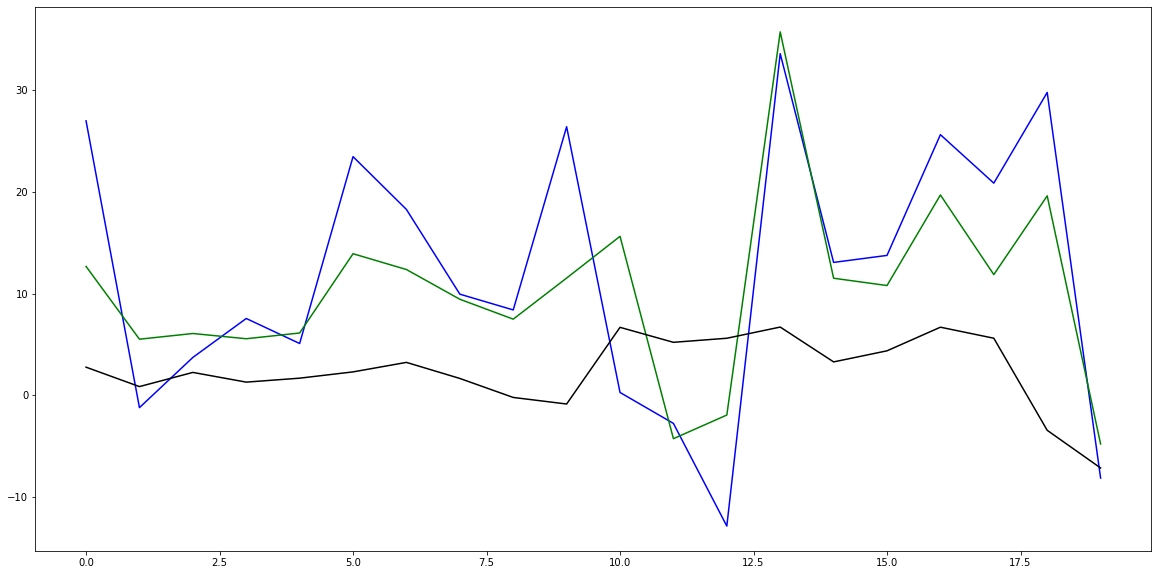

In [66]:
plt.figure(figsize = (20, 10))

plt.plot([np.nanmean(results[i][3][:12]) for i in range(len(results))], "blue")

plt.plot([np.nanmean(results[i][3][:]) for i in range(len(results))], "green")

plt.plot(sp500.loc[Dates_train_and_val[prediction_dates], "return_40"].values, "black")